# Using Minuit in Python

This tutorial focuses on how to use Minuit, a standard program for finding the minima of functions, from within Python. 

It assumes a general familiarity with Python and with the concept of ${\chi}^2$ in statistics. The last example assumes some knowledge of the analysis package [ROOT](https://root.cern.ch/).

You can copy the original of this notebook:

On the Nevis particle-physics cluster:
```bash 
cp ~seligman/root-class/minuit-class.ipynb <wherever>
```
Elsewhere:

`wget https://www.nevis.columbia.edu/~seligman/root-class/files/minuit-class.ipynb` or  
`curl -O https://www.nevis.columbia.edu/~seligman/root-class/files/minuit-class.ipynb`

### Useful links:

[iminuit tutorial](https://iminuit.readthedocs.io/en/latest/tutorials.html)  
... from which I have stolen liberally for this notebook.

[iminuit complete docs](https://iminuit.readthedocs.io/en/stable/reference.html)  
This has everything, but it's a little tricky to read if you're not familiar with Python [structures](https://docs.python.org/3/tutorial/datastructures.html) and [function returns](https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/). After going through this tutorial you'll be able to understand those docs and access all of Minuit's functionality.

[Minuit's Wikipedia page](http://en.wikipedia.org/wiki/MINUIT)  
The links on the page will take you to the original Minuit documentation (which fully discusses the minimization techniques and formulae) and the original Minuit paper if you want to include it in your bibliography. 

### Installing iminuit

In the Nevis particle-physics cluster, you don't have to do this. It's already installed when you do:

`module load python` (or `module load root/06.08.06` or earlier)

`module load python/3` (or `module load root` (06.10.xx or later))

or when you're on the [notebook server](https://notebook.nevis.columbia.edu) and you select one of the Python kernels; here's more on the [notebook server](https://twiki.nevis.columbia.edu/twiki/bin/view/Main/IPython). 

*Exception:* The above doesn't apply if you're using a python distribution from your collaboration's software suite (e.g., LArSoft for MicroBooNE; Athena for ATLAS).

Everyone else:
```
pip install iminuit
```
If you don't have admin access to your python installation:
```
pip install --user iminuit
```
(`pip` may be `pip3`, `pip3.6`, `pip3.7`, `pip-3.6`, `pip-3.7`, or something like that. It depends on the particulars of your python installation.)

## What is Minuit?

Minuit finds the minima of functions. I'll leave the details of how it's done to the complete Minuit documentation linked above. Basically, Minuit repeatedly evaluates a function, steps in intervals, numerically computes gradients, and follows the slope of the function until it reaches a minimum. 

Super-fast summary (more below):  
   * Migrad - find the function's minimum  
   * Hesse - more accurate matrix of correlation coefficients (if minimum is parabolic/symmetric)  
   * Minos - more accurate errors (if minimum is _not_ parabolic/symmetric)  

In [1]:
# Basic setup for this notebook
import math
import numpy as np
import matplotlib.pyplot as plt
import pprint
from iminuit import Minuit, cost

In [2]:
# Let's define the coefficients of a polynomial (easy to change and play with later)
coeff = np.array([1, 2, 5]) # x**2 + 2x + 5

In [3]:
# Simple polynomial evaluation with numpy
def polynomial(x):
    return np.polyval(coeff,x)

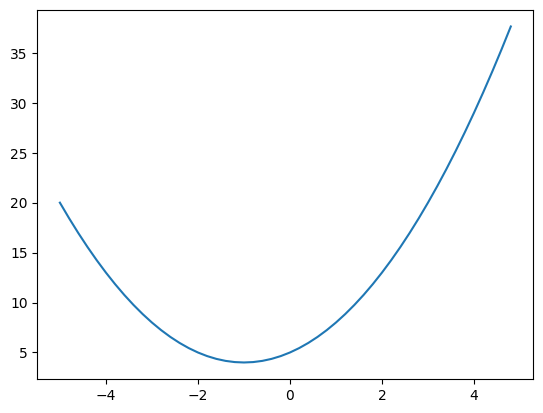

In [4]:
# Plot the polynomial on the interval (-5,5)
t = np.arange(-5., 5., 0.2)
plt.plot(t, polynomial(t))
plt.show()

Create a Minuit object. This won't perform a minimization yet. Note that you _must_ supply a starting value for each of your parameters; here the `polynomial` function has the single parameter `x`. 

In [5]:
m = Minuit(polynomial, x=0)

Although this is the default, defining it explictly will avoid annoying `errordef not defined` messages. Note that the value of 1.0 is valid for chi-squared fits; for negative log-likelihood fits use 0.5.

In [6]:
m.errordef = 1.0

This is equivalent, but it provides some documentation for the type of fit.

In [7]:
m.errordef = Minuit.LEAST_SQUARES

A quick look at our parameter(s). We've got only one. 

In [8]:
print(m.params)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.0    │    0.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


Find the function's minimum. This is the actual invocation of Minuit. Some items to look at in the output:
   * FCN = Value of the function the last time it was called. 
   * Nfcn = number of times function was called since the Minuit object was defined.
   * EDM = "Estimated Distance to Minimum"
   
`migrad` normally prints the final results of the fit (green means good, yellow means warning, purple means error). First there'll be a table with the parameters (note that here we have just one parameter) with values and errors. This is followed by a table of correlation coefficients between parameters, which will be pretty dull with only a single parameter.  

In [9]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4                          │              Nfcn = 11               │
│ EDM = 1.94e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    -1     │     1     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───┐
│   │ x │
├───┼───┤
│ x │ 1 │
└───┴───┘

## Accessing results

After the fit, we can access the `FMin` and `Param` structures to get at the fit results. If we hadn't captured the results of `migrad`, we can still get at the values from the fit:

In [10]:
fmin = m.fmin

In [11]:
param = m.params

If you just display these structures by themselves, they'll be formatted. 

In [12]:
fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4                          │              Nfcn = 11               │
│ EDM = 1.94e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [13]:
param

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x,-1,1,,,,,


I'll "pretty-print" the fit results so you can see how to access the values.

In [14]:
pprint.pprint(fmin)

<FMin algorithm='Migrad' edm=1.9406692881353272e-20 edm_goal=0.0002 errordef=1.0 fval=4.0 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=11 ngrad=0 reduced_chi2=nan time=0.0005464900004881201>


The structure may look visually confusing if you're not familiar with Python, but you can pick out the values you want with a bit of practice. For example, to get the value of the function at the minimum:

In [15]:
fmin.fval

4.0

In [16]:
pprint.pprint(param)

(Param(number=0, name='x', value=-0.9999999998601121, error=0.9999999999301152, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None),)


Note that 'param' is a list of dictionaries, with one entry in the list for each parameter. We only have one parameter in this fit, but we'll get to more later. 

Here's an example of accessing values in the returned structures. 

In [17]:
print ("function value at minimum = {:.3f}".format(fmin.fval))
for p in param:
    print ("minimum of variable {:s} = {:.3f} with error +/- {:.3f}".format(p.name,p.value,p.error))

function value at minimum = 4.000
minimum of variable x = -1.000 with error +/- 1.000


## Fixing and stepping parameters

We might want to do this if we have functions that we know are problematic in some regions, or we want to speed up Minuit's search for the minimum. 

Here's an example:

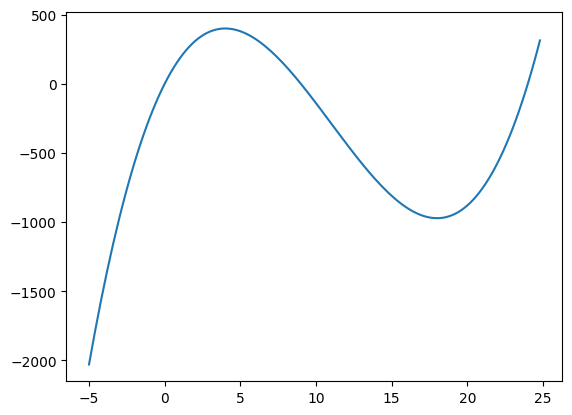

In [18]:
coeff = np.array([1, -33, 216, 0]) # x**3 - 33x**2 + 216x
t = np.arange(-5., 25., 0.2)
plt.plot(t, polynomial(t))
plt.show()

If we just left Minuit with `x` = 0, the fit procedure will "fall down the slope" towards negative x and go to "negative infinity".

In [19]:
m = Minuit(polynomial, x=0)
m.errordef = 1.0
m.migrad()

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4190                      │              Nfcn = 160              │
│ EDM = -4.19e+03 (Goal: 0.0002)   │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │  -7.8248  │  0.0000   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

So you sometimes must specify intelligent starting values for your function's parameters. In this case, we start `x` in a region with a local minimum. Then Minuit can find that low point. 

In [20]:
m = Minuit(polynomial, x=10)
m.errordef = 1.0
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -972                       │              Nfcn = 31               │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   18.00   │   0.22    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      x │
├───┼────────┤
│ x │ 0.0476 │
└───┴────────┘

Searching for function minima, especially with functions with multiple parameters you can't easily plot, can sometimes be tricky. This will be our last example of a function with a single parameter that we can plot simply:

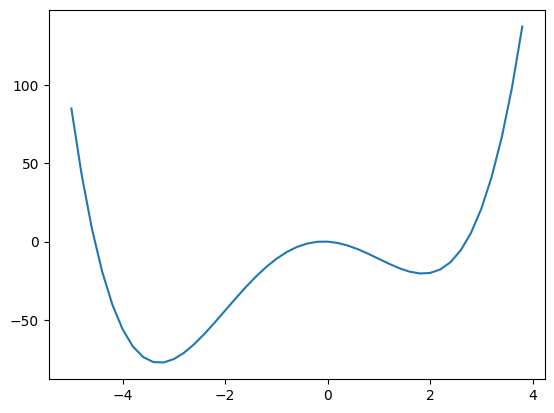

In [21]:
coeff = np.array([1, 2, -12, -2, 0]) # x**4 + 2x**3 - 12x**2 - 2x
t = np.arange(-5., 4., 0.2)
plt.plot(t, polynomial(t))
plt.show()

If we start at `x` = 0, Minuit will follow the direction of the slope and find that local minimum:

In [22]:
m = Minuit(polynomial, x=0)
m.errordef = 1.0
m.migrad()

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -20.4                      │              Nfcn = 115              │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   1.86    │   0.22    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────┐
│   │    x │
├───┼──────┤
│ x │ 0.05 │
└───┴──────┘

Of course, if you want to find the true minimum and you know roughly where it is, you can set an appropriate starting value:

In [23]:
m = Minuit(polynomial, x = -0.5)
m.errordef = 1.0
m.migrad()

E VariableMetricBuilder Initial matrix not pos.def.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -77.37                     │              Nfcn = 83               │
│ EDM = 8.45e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -3.28   │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      x │
├───┼────────┤
│ x │ 0.0304 │
└───┴────────┘

Minuit can do some plotting so you can examine the behavior of your function. This is described below. 

## Fitting to ${\chi}^2$ functions

In a physics analysis, you're not typically trying to find the minimum of an analytic function like a polynomial. You normally are trying to compare an observed distribution with a prediction (theory, simulation, etc.). 

In this tutorial, I'm only going to cover comparing data vs. prediction using a ${\chi}^2$ function, which basically assumes the errors in your data are all Gaussian and there aren't any "pull" terms such as those associated with systematic errors. The common alternative is a log-likelihood fit. It can be difficult sometimes to understand which data vs. prediction method should be used for your analysis. (As for me, I just ask Mike Shaevitz.)

If you're doing a log-likelihood fit, you'll want to set the Minuit parameter `errordef` to 0.5. For least-squares ${\chi}^2$ fits, you want `errordef` to be 1.0 (the default). 

Let's start with a function that defines our prediction as a function of some parameters. Since I'm a simple person, my prediction will be equally simple: I'm manually coding a gaussian distribution for the fitting function. It's easy to find a pre-built gaussian function in packages like [Numpy](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) and [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). I'm coding it explicitly here because, unless you're really lucky, in most physics analyses the underlying function may not be a simple pre-built distribution. 



In [24]:
def prediction(x, mean=0.0, sigma=1.0, amp=1.0):
    return amp*math.exp(-0.5*(x - mean)**2 / sigma**2)

Now we need data to compare with the prediction. Here I create "fake data" by smearing the prediction with a normal distribution. (I'm doubly cheating here: My prediction is a gaussian, and my errors are gaussian. In real life there are no cheats!)

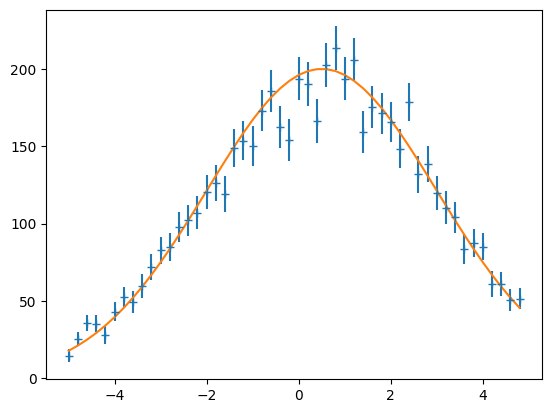

In [25]:
t = np.arange(-5., 5., 0.2)
val = np.zeros((len(t)))
err = np.zeros((len(t)))
pred = np.zeros((len(t)))
for i in range(0,len(t)):
    pred[i] = prediction(t[i],0.5,2.5,200.) # number of "events"
    err[i] = math.sqrt(pred[i])             # error is sqrt(number of events)
    val[i] = np.random.normal(pred[i],err[i])

# Let's take a look. 
plt.errorbar(t, val, err, None, '+')
plt.plot(t,pred)
plt.show()

We have our data and our prediction. Now we'll define the ${\chi}^2$ between data and prediction as a function of the prediction's parameters. 

In [26]:
def chi2_prediction(a, b, c):
    sum = 0.
    for i in range(0,len(t)):
        predict = prediction(t[i], a, b, c)
        sum += (val[i] - predict) ** 2 / err[i]**2
    return sum

Create a new Minuit object and perform the fit. 

In [27]:
minuit = Minuit(chi2_prediction, a = 0, b = 0, c = 0)
minuit.errordef = 1.0
minuit.migrad()

/tmp/ipykernel_6856/1244826761.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return amp*math.exp(-0.5*(x - mean)**2 / sigma**2)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5773                       │              Nfcn = 120              │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │     0     │     0     │            │            │         │         │       │
│ 1 │ b    │     0     │     0     │            │            │         │         │       │
│ 2 │ c    │     0     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

**Gloom! Doom! Nightmare!** What happened? In this case, the problem can be easily solved if we look carefully at the error message. 

Now it's clear: We idly set the initial values of all our parameters to zero, and we got into trouble in the `prediction` function when sigma=0. One way to solve this is to supply better starting values (we'll learn another way below). Note how the Pythonized Minuit is able to associate the names of the arguments in the chi2_prediction with parameters you can assign values to. 

In [28]:
minuit = Minuit(chi2_prediction, 
                a=1, b=1, c=1)
minuit.errordef = 1.0
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 161              │
│ EDM = 3.06e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │            │            │         │         │       │
│ 2 │ c    │   190.8   │    3.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

Look at Nfcn in the output above. That's the number of times we called the `chi2_prediction` function. As a general rule, if a Minuit fit is taking a long time, try to optimize the function you're minimizing. It's not unusual in multi-parameter fits for that function to be called thousands of times. 

## Passing options to Minuit

To control (and access) any other aspect of Minuit other than the parameter values, you must use arrays. For example, to set the initial step sizes for the fit, use the `errors` array; you sometimes want to change from the default of 1 to either force Minuit to explore large regions or to have it start in a small region. 

_Reminder:_ The `a`, `b`, and `c` in these parameter names comes from the names of the arguments in the function we passed to Minuit. If I defined the function as 
```python
def chi2_prediction(pooh, piglet, eeyore)
```
then the names of the error arguments would be `errors["pooh"]`, `errors["piglet"]`, `errors["eeyore"]`. 

In [29]:
minuit = Minuit(chi2_prediction, a=1, b=1, c=5)
minuit.errordef = 1.0
minuit.errors['a'] = 0.1
minuit.errors['b'] = 0.1
minuit.errors['c'] = 0.1

In [30]:
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 150              │
│ EDM = 4.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │            │            │         │         │       │
│ 2 │ c    │   190.8   │    3.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

An advantage of using a dictionary to pass arguments is that you can change the values in the dictionary without creating a new Minuit object. Note the values of `Nfcn` and its total between the output of the cell above and the one below. 

In [31]:
minuit.errors['a'] = 1
minuit.errors['b'] = 1
minuit.errors['c'] = 1
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 172              │
│ EDM = 1.72e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │            │            │         │         │       │
│ 2 │ c    │   190.8   │    3.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

In an analysis, it's not unusual to fix one or more parameters to a specific value. I'll start with fresh batch of arguments so you can see how it works. 

In [32]:
minuit = Minuit(chi2_prediction, a=1, b=1, c=200)
minuit.errordef = 1.0
minuit.errors['a'] = 0.1
minuit.errors['b'] = 0.1
minuit.fixed['c'] = True

minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 50.27                      │              Nfcn = 55               │
│ EDM = 9.19e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.52    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.530   │   0.028   │            │            │         │         │       │
│ 2 │ c    │    200    │     2     │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │  0.00149   0.2e-3   0.0000 │
│ b │   0.2e-3 0.000793        0 │
│ c │   0.0000        0        0 │
└───┴────────────────────────────┘

We can set limits on the values of parameters, e.g., to keep a value from wandering into a completely non-physical value. If you set a limit, what Minuit actually does is create an internal variable that goes to &plusmn;Infinity as the value of the external (your) variable approaches its lower and upper limits. Here's a simple example that solves the `b=0` problem we saw above. There's more on this topic in the [iminuit tutorial](https://iminuit.readthedocs.io/en/stable/tutorial/basic_tutorial.html).

In [33]:
minuit = Minuit(chi2_prediction, a = 1, b = 1, c = 200)
minuit.errordef = 1
minuit.limits['b'] = (0,1000)
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 78               │
│ EDM = 6.67e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │            │            │    0    │  1000   │       │
│ 2 │ c    │   190.8   │    3.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

## Exploring fit results

Let's look at the results and parameters using the same code as for our polynomial fits.

In [34]:
print ("function value at minimum = {:.3f}".format(minuit.fmin.fval))
for p in minuit.params:
    print ("minimum of variable {:s} = {:.3f} with error +/- {:.3f}".format(p.name,p.value,p.error))

function value at minimum = 42.688
minimum of variable a = 0.526 with error +/- 0.040
minimum of variable b = 2.598 with error +/- 0.039
minimum of variable c = 190.764 with error +/- 3.334


For ${\chi}^2$ functions, one way to tell you have a "good" fit if the value of ${\chi}^2$/(degrees of freedom) is about 1. For a typical fit, the number of degrees of freedom (NDF) is the number of data points minus the number of free parameters in the fit. 

In addition to the methods described above, you can also get results directly from the Minuit object after the fit.

In [35]:
minuit.values

<ValueView a=0.5256013089052284 b=2.598464358321149 c=190.7641044847503>

In [36]:
minuit.errors

<ErrorView a=0.04035669449824021 b=0.03935281436432958 c=3.3341366560235284>

Let's take a look at the covariance matrix ${\sigma_{ij}}$, which gives us a sense of the correlations between parameters; if the parameters aren't correlated at all, this will be a diagonal matrix (not true in this case). Note that the diagonal ${\sigma_{ii}}$ are the squares of the corresponding parabolic errors. 

In [37]:
minuit.covariance

,a,b,c
a,0.00163,0.0004 (0.229),-0.0131 (-0.098)
b,0.0004 (0.229),0.00155,-0.0856 (-0.653)
c,-0.0131 (-0.098),-0.0856 (-0.653),11.1


It can also be useful to look at the matrix of correlation coefficients $({\sigma_{ij}})/(\sigma_{ii}\sigma_{jj})^{1/2}$

In [38]:
minuit.covariance.correlation()

,a,b,c
a,1,0.2,-0.1
b,0.2,1,-0.7
c,-0.1,-0.7,1


If we need a more accurate error matrix, use the Minuit routine `Hesse` after you've minimized with `Migrad`. 

Here we see that parameter `b` is correlated with `c` (the width of the gaussian in our prediction is correlated with the amplitude). 

Hesse re-computes the error matrix, so it involves more calls to the function you supplied to Minuit.

In [39]:
minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 94               │
│ EDM = 6.66e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │            │            │    0    │  1000   │       │
│ 2 │ c    │   190.8   │    3.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

Here we have the luxury of knowing that our parameter errors are symmetric about their minima (by construction); in multi-dimensional terms, our function is hyper-parabolic about all minima (the third and higher-level derivatives are close to zero). In real analyses we often find that errors are not symmetric, which means that the covariance matrix and the error matrix from Hesse are not correct. 

To get a better sense of the true errors, use `Minos`, which computes the true confidence regions about the minima. Minos calls the function you supplied to Minuit many times (roughly an order of magnitude more than just doing the fit), so only call it if you suspect you need it. 

Here we see confirm that our errors are reasonably symmetric about the minima of our `chi2_prediction` function (the `Hesse` error, `Minos Error-`, and `Minos Error+` columns are the same). 

In [40]:
minuit.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.69                      │              Nfcn = 206              │
│ EDM = 6.66e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.53    │   0.04    │   -0.04    │    0.04    │         │         │       │
│ 1 │ b    │   2.60    │   0.04    │   -0.04    │    0.04    │    0    │  1000   │       │
│ 2 │ c    │   190.8   │    3.3    │    -3.3    │    3.3     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │           c           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.04   │   0.04    │   -0.04   │   0.04    │   -3.3    │    3.3    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00163  0.0004 -0.0131 │
│ b │  0.0004 0.00155 -0.0856 │
│ c │ -0.0131 -0.0856    11.1 │
└───┴─────────────────────────┘

`Hesse` and `Minos` return structures from which you can extract values. `Hesse` returns a list of dictionaries, and `Minos` returns a dictionary of dictionaries. 

You can draw two-parameter contour plots, which in addition to looking pretty can also give you a sense of the error correlations. In `result`, which I'll let you print for yourself, are numpy arrays containing the points used to generate the plot.

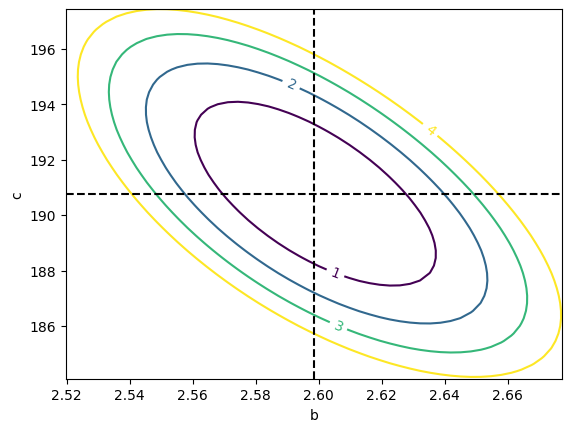

In [41]:
result = minuit.draw_contour('b','c')

If you want to see the Minos contours:

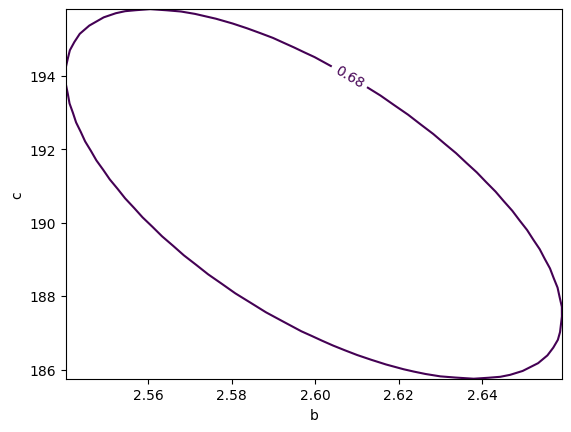

In [42]:
result_minos = minuit.draw_mncontour('b','c')

For the minimum of a single parameter:

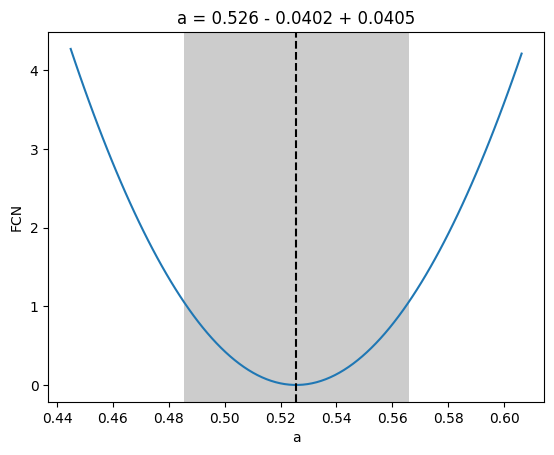

In [43]:
result_profile = minuit.draw_profile('a')

## A more realistic example

Let's get closer to a fit that you might actually do. 

In this example, a ROOT TTree contains branches with the variables `elepton` and `ehadron`, the amount of leptonic and hadronic energy in each event. In the paper by Prof. B. Ryter Tenu there's a theory to predict the spectrum of leptonic and hadronic energies. Our task is to read the values from the TTree and fit to Tenu's theory. 

To get `datafile.root`:

On the Nevis particle-physics cluster:
```sh
cp ~seligman/root-class/datafile.root <wherever>
```
Elsewhere:

`wget https://www.nevis.columbia.edu/~seligman/root-class/files/datafile.root` or  
`curl -O https://www.nevis.columbia.edu/~seligman/root-class/files/datafile.root`

In [44]:
import ROOT
# Open the file of data events.
datafile = ROOT.TFile( 'datafile.root' )
tree = ROOT.gDirectory.Get( 'datatree' )
entries = tree.GetEntriesFast()

Welcome to JupyROOT 6.28/02


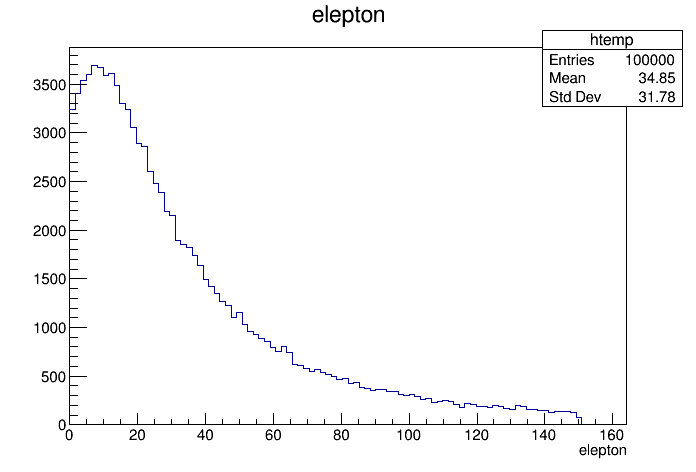

In [45]:
# Let's make a couple of test histograms to find the range of our variables.
canvas = ROOT.TCanvas()
tree.Draw("elepton")
canvas.Draw()

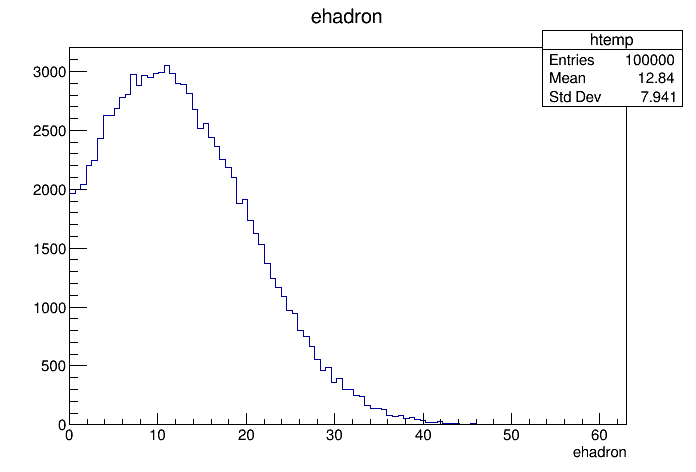

In [46]:
tree.Draw("ehadron")
canvas.Draw()

This suggests that it will be sufficient to bin `elepton` and `ehadron` from 0 to 150. *(Someone forgot to specify units! Sloppy!)*

In [47]:
eleptonHist = ROOT.TH1D("elepton","elepton histogram",100,0,150)
ehadronHist = ROOT.TH1D("ehadron","ehadron histogram",100,0,150)

# Sum the errors correctly (just in case; typically you
# only need this if you're going to perform histogram
# arithmentic and the weights are different from 1).
eleptonHist.Sumw2()
ehadronHist.Sumw2()

In [48]:
for entry in range(entries):
    # Copy next entry into memory and verify.
    nb = tree.GetEntry( entry )
    if nb <= 0:
        continue
    eleptonHist.Fill(tree.elepton)
    ehadronHist.Fill(tree.ehadron)

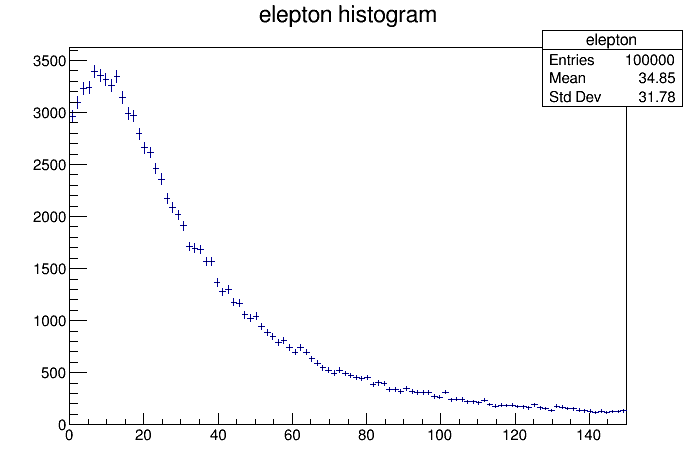

In [49]:
eleptonHist.Draw('E')
canvas.Draw()

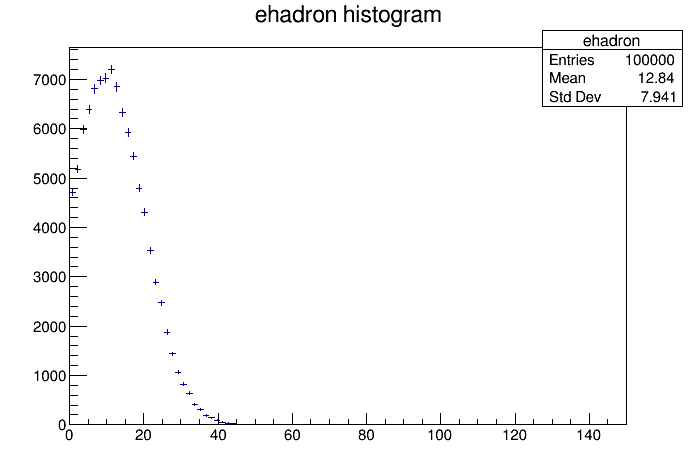

In [50]:
ehadronHist.Draw('E')
canvas.Draw()

*We're still being sloppy with units! You call this an analysis? And I thought we were through with pretty pictures!*

We form a ${\chi}^2$ by going through the histogram bins and comparing the data with the theory. We want to include the normalization between the number of events in the data and the spectrum predicted by the theory; that's the `norm` parameter.

If you're familiar with ROOT, you'll realize that we could have used TH1::Fit() for this instead of an explicit call to Minuit. In a realistic analysis, instead of getting data and errors from histograms you'll get them from a more complex process; typically you'll still loop over some data points vs. predicted points as shown here. 

The main reason I'm using histograms for this example is that it gives me a good excuse for making the errors purely statistical. If I compared individual data points against Prof. Tenu's theory, I'd have to ask what the error on a single point is. The answer probably involves systematic effects, and that requires something more than a simple ${\chi^2}$ function. 

In [51]:
def chi2_theory(alpha, beta, gamma, norm):
    numberBins = eleptonHist.GetNbinsX()
    chi2 = 0.
    # ROOT histograms start with bin #1.
    for bin in range(1,numberBins+1):
        energy = eleptonHist.GetBinCenter(bin)
        
        leptonData = eleptonHist.GetBinContent(bin)
        leptonErr = eleptonHist.GetBinError(bin)
        
        hadronData = ehadronHist.GetBinContent(bin)
        hadronErr = ehadronHist.GetBinError(bin)
        
        # Here's Prof. Tenu's theory, which depends on three parameters (alpha, beta, gamma).
        leptonPred = ROOT.Math.landau_pdf(energy,alpha,gamma)
        hadronPred = ROOT.Math.gaussian_pdf(energy,beta,gamma)
        
        if leptonErr > 0:
            chi2 += (norm*leptonPred - leptonData)**2 / leptonErr**2
        if hadronErr > 0:
            chi2 += (norm*hadronPred - hadronData)**2 / hadronErr**2
        
    return chi2

Set up the arguments for Minuit. I've introduced a few frills as examples:
   * Prof. Tenu's theory tells us that alpha, beta, and gamma must be greater than zero. 
   * If we're fitting `norm` for the normalization between data and theory, a reasonable starting value is the number of data events.

In [52]:
m = Minuit(chi2_theory, alpha = 1, beta = 1, gamma = 1, norm = float(entries))
m.errordef = 1.0
m.limits['alpha'] = (0., None) # Can vary from 0 to infinity
m.limits['beta'] = (0., None)
m.limits['gamma'] = (0., None)

Let's do it!

In [53]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 212                        │              Nfcn = 288              │
│ EDM = 5.9e-06 (Goal: 0.0002)     │            time = 8.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   9.87    │   0.05    │            │            │    0    │         │       │
│ 1 │ beta  │   10.12   │   0.04    │            │            │    0    │         │       │
│ 2 │ gamma │   9.81    │   0.05    │            │            │    0    │         │       │
│ 3 │ norm  │  182.9e3  │   0.5e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │    alpha     beta    gamma     norm │
├───────┼─────────────────────────────────────┤
│ alpha │  0.00233   0.0003  -0.0006   9.7558 │
│  beta │   0.0003  0.00134  -0.0014  10.5698 │
│ gamma │  -0.0006  -0.0014  0.00293 -18.1639 │
│  norm │   9.7558  10.5698 -18.1639 3.02e+05 │
└───────┴─────────────────────────────────────┘

In [54]:
print ("function value at minimum = {:.3f}".format(m.fmin.fval))
for p in m.params:
    print ("minimum of variable {:s} = {:.3f} with error +/- {:.3f}".format(p.name,p.value,p.error))
    
result = m.hesse()

function value at minimum = 211.962
minimum of variable alpha = 9.870 with error +/- 0.048
minimum of variable beta = 10.122 with error +/- 0.037
minimum of variable gamma = 9.815 with error +/- 0.054
minimum of variable norm = 182903.541 with error +/- 549.311


If you want to compare the values of `alpha`, `beta`, and `gamma` from the fit with the ones that generated the "data" for `datafile.root`, see [`minuit-class-setup.ipynb`](https://nbviewer.org/urls/www.nevis.columbia.edu/~seligman/root-class/files/minuit-class-setup.ipynb). Note that this is a ROOT C++ notebook. 

If you'd like a copy of the setup notebook:

On the Nevis particle-physics cluster:
```bash 
cp ~seligman/root-class/minuit-class-setup.ipynb <wherever>
```
Elsewhere:

`wget https://www.nevis.columbia.edu/~seligman/root-class/files/minuit-class-setup.ipynb` or  
`curl -O https://www.nevis.columbia.edu/~seligman/root-class/files/minuit-class-setup.ipynb`

It wasn't easy to figure out that if I generated events from a Gaussian or Landau distribution, I had to fit that event population using the Gaussian or Landau PDFs!

## Random notes

If you'd like to use numpy arrays (useful if you have a large number of parameters to pass to your function), iminuit supports them. See the [iminuit tutorial](https://iminuit.readthedocs.io/en/stable/tutorials.html) for more information. 

Minuit is also available in ROOT; it's the underlying algorithm for histogram fits. If you want access to the full functionality of Minuit, you can use the [TMinuit class](https://root.cern.ch/doc/master/classTMinuit.html). This class's interface is like the original FORTRAN, and it is not as easy to use as the iminuit version. You can see examples in the [ROOT fit tutorials](https://root.cern.ch/doc/master/group__tutorial__fit.html); for example, routine [Ifit.C](https://root.cern.ch/doc/master/Ifit_8C.html).

This rarely happens in a physics analysis, but if the function you're minimizing has a gradient that you can compute analytically, you can supply a gradient function using the `grad=<function>` option in Minuit. This will greatly speed up Minuit, which otherwise has to calculate gradients numerically with multiple calls to your main function. See the [iminuit documentation](https://iminuit.readthedocs.io/en/stable/reference.html) for more information. 

Another way to speed up iminuit is to code part or all of the function to be minimized in [Cython](http://docs.cython.org/en/latest/). The [iminuit tutorial](https://iminuit.readthedocs.io/en/stable/notebooks/cython.html) shows how to do this. Cython is available in the Nevis Python installations. 

You may also want to consider ROOT's [RooFit](https://root.cern/manual/roofit/) package for performing fits. This package is useful if you have a large number of data points, don't want to bin your data, and/or are working with PDFs as in the "theory" part of the above example. 

Another alternative fitting package is [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which is in the standard Python scipy.optimize package. 

As a generalized function-minimization program, Minuit is necessarily slower than a routine custom-written for your application. In particular, Minuit is a poor choice for track-fitting. 